## Import the Libraries

In [1]:
!pip install timm torch torchvision


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import timm
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [3]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

label_file = pd.read_csv('Dataset/labels_file.csv')
label_file_clean = label_file.dropna(subset=['choice'])

# Extract and clean
image_paths = label_file_clean['image'].apply(os.path.basename).tolist()
labels = label_file_clean['choice'].tolist()

# Encode labels (e.g., casual → 0, streetwear → 1, etc.)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # numpy array of integers


In [4]:
from PIL import Image
from torch.utils.data import Dataset

class FashionCSVDataset(Dataset):
    def __init__(self, image_paths, labels, image_dir, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader

# Split first
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Dataset instances (only once — your previous code had duplicates)
image_dir = "Dataset/images"

train_dataset = FashionCSVDataset(train_paths, train_labels, image_dir, train_transform)
val_dataset   = FashionCSVDataset(val_paths, val_labels, image_dir, val_transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)


In [6]:
import timm
import torch.nn as nn
import torch

# Load EfficientNet with pretrained ImageNet weights
model = timm.create_model('efficientnet_b0', pretrained=True)

# Replace classifier head
num_classes = len(set(encoded_labels))  # e.g., 5 styles
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier.in_features, num_classes)
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ravis\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
from tqdm import tqdm
from sklearn.metrics import classification_report

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%\n")

    # ➕ Add this for classification report
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))



Epoch 1/20: 100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Train Loss: 1.6192 | Train Acc: 22.80%
Val Loss: 1.5492 | Val Acc: 35.90%

              precision    recall  f1-score   support

      casual       0.29      0.13      0.18        30
      formal       0.31      0.33      0.32        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.48      0.76      0.59        37
     vintage       0.22      0.12      0.16        16

    accuracy                           0.36       117
   macro avg       0.26      0.27      0.25       117
weighted avg       0.32      0.36      0.32       117



Epoch 2/20: 100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


Train Loss: 1.4377 | Train Acc: 46.67%
Val Loss: 1.4774 | Val Acc: 43.59%

              precision    recall  f1-score   support

      casual       0.33      0.20      0.25        30
      formal       0.61      0.46      0.52        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.44      0.89      0.59        37
     vintage       0.25      0.06      0.10        16

    accuracy                           0.44       117
   macro avg       0.33      0.32      0.29       117
weighted avg       0.38      0.44      0.37       117



Epoch 3/20: 100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


Train Loss: 1.2916 | Train Acc: 57.20%
Val Loss: 1.4456 | Val Acc: 44.44%

              precision    recall  f1-score   support

      casual       0.38      0.20      0.26        30
      formal       0.57      0.50      0.53        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.44      0.89      0.59        37
     vintage       0.25      0.06      0.10        16

    accuracy                           0.44       117
   macro avg       0.33      0.33      0.30       117
weighted avg       0.39      0.44      0.38       117



Epoch 4/20: 100%|██████████| 15/15 [00:44<00:00,  2.96s/it]


Train Loss: 1.1573 | Train Acc: 64.30%
Val Loss: 1.4149 | Val Acc: 45.30%



b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

      casual       0.31      0.17      0.22        30
      formal       0.59      0.54      0.57        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.45      0.92      0.61        37
     vintage       0.25      0.06      0.10        16

    accuracy                           0.45       117
   macro avg       0.32      0.34      0.30       117
weighted avg       0.38      0.45      0.38       117



Epoch 5/20: 100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


Train Loss: 1.0120 | Train Acc: 73.55%
Val Loss: 1.4092 | Val Acc: 45.30%



b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

      casual       0.29      0.17      0.21        30
      formal       0.54      0.54      0.54        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.47      0.89      0.62        37
     vintage       0.33      0.12      0.18        16

    accuracy                           0.45       117
   macro avg       0.33      0.35      0.31       117
weighted avg       0.38      0.45      0.39       117



Epoch 6/20: 100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


Train Loss: 0.8705 | Train Acc: 79.14%
Val Loss: 1.3939 | Val Acc: 43.59%



b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

      casual       0.33      0.23      0.27        30
      formal       0.48      0.58      0.53        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.48      0.76      0.59        37
     vintage       0.22      0.12      0.16        16

    accuracy                           0.44       117
   macro avg       0.30      0.34      0.31       117
weighted avg       0.37      0.44      0.39       117



Epoch 7/20: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Train Loss: 0.6976 | Train Acc: 88.17%
Val Loss: 1.3964 | Val Acc: 44.44%



b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

      casual       0.36      0.27      0.31        30
      formal       0.48      0.67      0.56        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.51      0.70      0.59        37
     vintage       0.18      0.12      0.15        16

    accuracy                           0.44       117
   macro avg       0.31      0.35      0.32       117
weighted avg       0.38      0.44      0.40       117



Epoch 8/20: 100%|██████████| 15/15 [01:08<00:00,  4.58s/it]


Train Loss: 0.5783 | Train Acc: 89.68%
Val Loss: 1.4123 | Val Acc: 43.59%

              precision    recall  f1-score   support

      casual       0.35      0.27      0.30        30
      formal       0.46      0.54      0.50        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.51      0.70      0.59        37
     vintage       0.29      0.25      0.27        16

    accuracy                           0.44       117
   macro avg       0.32      0.35      0.33       117
weighted avg       0.38      0.44      0.40       117



Epoch 9/20: 100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


Train Loss: 0.4538 | Train Acc: 93.76%
Val Loss: 1.4433 | Val Acc: 43.59%

              precision    recall  f1-score   support

      casual       0.42      0.47      0.44        30
      formal       0.50      0.54      0.52        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.50      0.57      0.53        37
     vintage       0.21      0.19      0.20        16

    accuracy                           0.44       117
   macro avg       0.33      0.35      0.34       117
weighted avg       0.40      0.44      0.42       117



Epoch 10/20: 100%|██████████| 15/15 [01:09<00:00,  4.61s/it]


Train Loss: 0.3510 | Train Acc: 96.77%
Val Loss: 1.4808 | Val Acc: 40.17%

              precision    recall  f1-score   support

      casual       0.33      0.37      0.35        30
      formal       0.55      0.50      0.52        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.49      0.57      0.53        37
     vintage       0.18      0.19      0.18        16

    accuracy                           0.40       117
   macro avg       0.31      0.32      0.32       117
weighted avg       0.38      0.40      0.39       117



Epoch 11/20: 100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


Train Loss: 0.2571 | Train Acc: 97.42%
Val Loss: 1.5581 | Val Acc: 40.17%

              precision    recall  f1-score   support

      casual       0.36      0.30      0.33        30
      formal       0.48      0.54      0.51        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.49      0.59      0.54        37
     vintage       0.17      0.19      0.18        16

    accuracy                           0.40       117
   macro avg       0.30      0.32      0.31       117
weighted avg       0.37      0.40      0.38       117



Epoch 12/20: 100%|██████████| 15/15 [01:09<00:00,  4.61s/it]


Train Loss: 0.1954 | Train Acc: 99.14%
Val Loss: 1.5682 | Val Acc: 38.46%

              precision    recall  f1-score   support

      casual       0.35      0.30      0.32        30
      formal       0.54      0.54      0.54        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.48      0.54      0.51        37
     vintage       0.14      0.19      0.16        16

    accuracy                           0.38       117
   macro avg       0.30      0.31      0.31       117
weighted avg       0.37      0.38      0.38       117



Epoch 13/20: 100%|██████████| 15/15 [01:08<00:00,  4.60s/it]


Train Loss: 0.1520 | Train Acc: 99.35%
Val Loss: 1.6211 | Val Acc: 35.04%

              precision    recall  f1-score   support

      casual       0.31      0.30      0.31        30
      formal       0.48      0.46      0.47        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.45      0.49      0.47        37
     vintage       0.14      0.19      0.16        16

    accuracy                           0.35       117
   macro avg       0.27      0.29      0.28       117
weighted avg       0.34      0.35      0.34       117



Epoch 14/20: 100%|██████████| 15/15 [01:03<00:00,  4.24s/it]


Train Loss: 0.1149 | Train Acc: 99.78%
Val Loss: 1.6716 | Val Acc: 36.75%

              precision    recall  f1-score   support

      casual       0.35      0.30      0.32        30
      formal       0.48      0.50      0.49        24
      sporty       0.29      0.20      0.24        10
  streetwear       0.46      0.46      0.46        37
     vintage       0.14      0.19      0.16        16

    accuracy                           0.37       117
   macro avg       0.34      0.33      0.33       117
weighted avg       0.38      0.37      0.37       117



Epoch 15/20: 100%|██████████| 15/15 [01:01<00:00,  4.09s/it]


Train Loss: 0.0886 | Train Acc: 100.00%
Val Loss: 1.7418 | Val Acc: 40.17%

              precision    recall  f1-score   support

      casual       0.38      0.27      0.31        30
      formal       0.50      0.54      0.52        24
      sporty       0.38      0.30      0.33        10
  streetwear       0.45      0.54      0.49        37
     vintage       0.17      0.19      0.18        16

    accuracy                           0.40       117
   macro avg       0.38      0.37      0.37       117
weighted avg       0.40      0.40      0.40       117



Epoch 16/20: 100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


Train Loss: 0.0590 | Train Acc: 100.00%
Val Loss: 1.7970 | Val Acc: 36.75%

              precision    recall  f1-score   support

      casual       0.40      0.27      0.32        30
      formal       0.44      0.50      0.47        24
      sporty       0.30      0.30      0.30        10
  streetwear       0.43      0.43      0.43        37
     vintage       0.17      0.25      0.21        16

    accuracy                           0.37       117
   macro avg       0.35      0.35      0.35       117
weighted avg       0.38      0.37      0.37       117



Epoch 17/20: 100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


Train Loss: 0.0588 | Train Acc: 100.00%
Val Loss: 1.8213 | Val Acc: 39.32%

              precision    recall  f1-score   support

      casual       0.42      0.27      0.33        30
      formal       0.43      0.54      0.48        24
      sporty       0.33      0.30      0.32        10
  streetwear       0.49      0.49      0.49        37
     vintage       0.18      0.25      0.21        16

    accuracy                           0.39       117
   macro avg       0.37      0.37      0.36       117
weighted avg       0.40      0.39      0.39       117



Epoch 18/20: 100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


Train Loss: 0.0479 | Train Acc: 100.00%
Val Loss: 1.8093 | Val Acc: 37.61%

              precision    recall  f1-score   support

      casual       0.43      0.33      0.38        30
      formal       0.38      0.46      0.42        24
      sporty       0.30      0.30      0.30        10
  streetwear       0.48      0.41      0.44        37
     vintage       0.21      0.31      0.25        16

    accuracy                           0.38       117
   macro avg       0.36      0.36      0.36       117
weighted avg       0.40      0.38      0.38       117



Epoch 19/20: 100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


Train Loss: 0.0360 | Train Acc: 99.57%
Val Loss: 1.8494 | Val Acc: 35.90%

              precision    recall  f1-score   support

      casual       0.38      0.27      0.31        30
      formal       0.44      0.50      0.47        24
      sporty       0.27      0.30      0.29        10
  streetwear       0.44      0.43      0.44        37
     vintage       0.14      0.19      0.16        16

    accuracy                           0.36       117
   macro avg       0.34      0.34      0.33       117
weighted avg       0.37      0.36      0.36       117



Epoch 20/20: 100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


Train Loss: 0.0342 | Train Acc: 100.00%
Val Loss: 1.8545 | Val Acc: 37.61%

              precision    recall  f1-score   support

      casual       0.42      0.27      0.33        30
      formal       0.48      0.54      0.51        24
      sporty       0.23      0.30      0.26        10
  streetwear       0.46      0.46      0.46        37
     vintage       0.14      0.19      0.16        16

    accuracy                           0.38       117
   macro avg       0.35      0.35      0.34       117
weighted avg       0.39      0.38      0.38       117



In [9]:
torch.save(model.state_dict(), "efficientnet_fashion_model.pth")

In [10]:
def predict_image(image_path, model, transform, index_to_label):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return index_to_label[predicted.item()]


In [11]:
image_path = "Dataset/images/00892049-fashion_295.jpg"
index_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

predicted_label = predict_image(image_path, model, val_transform, index_to_label)
print("Predicted style:", predicted_label)

Predicted style: formal


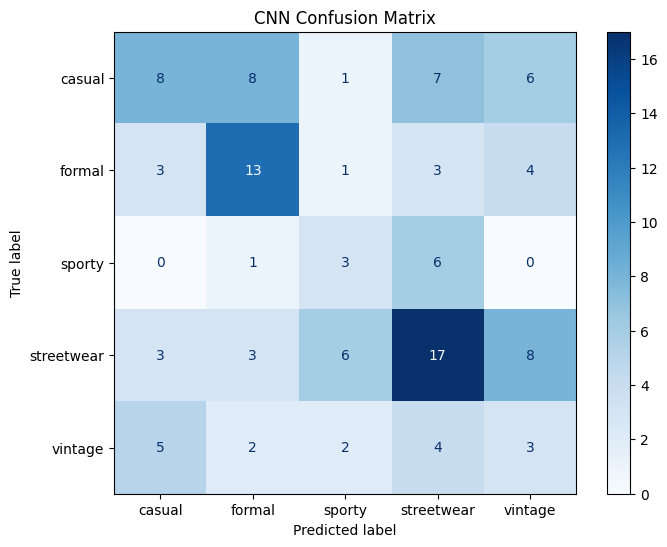

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After getting y_true and y_pred in your notebook:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.savefig("cnn_confusion_matrix.png")  # Save the image
plt.show()